# Binned plots to match the ones from the observations paper
Instead of radar-lidar, do qtot > 5x10^-5 kg/kg limit

In [1]:
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts")
import pickle

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import bin_overshoot as bin_os
import get_d2_data as get_d2
import bin_obs_overshoot as boo

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [4]:
file_path = "/work/bb1153/b380887/10x10/"
# pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/tb_corrected_binned/"
# diff_pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/new_d2_tb_hists/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/d2_paper_poster/binned_plots/"
# pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/racp_cirrus_binned/"
pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/tb_corrected_binned/new_thresh/"


In [5]:
model_list = ["OBS", "SHIELD", "GEOS", "SCREAM"] #, "SAM", "ICON"] 
region_list = ["SPC", "AMZ"] #, "TIM", "SCA"]


#### Observations (smaller regions)
NOT used in the paper

In [6]:
save_obs_dicts = False


In [7]:
year_list = [2007, 2008, 2009, 2010]
years_sorted = list(sorted(year_list))
years_str = str(years_sorted[0]) + "-" + str(years_sorted[-1])
print(years_str)

pickle_dir_obs = "/home/b/b380887/cold-point-overshoot/pickle_files/tb_corrected_binned/obs_all_years/"
pickle_dir_bin = "/home/b/b380887/cold-point-overshoot/pickle_files/binned_by_tb/climo/new_bins/"


2007-2010


In [8]:
def get_binned_data_all_years(region_list, year_list, file_path):
    """ 
    Get cold point-relative dardar and (Tb - cpT) for all years in 
    DJF for the observations
    """
    diffs_dar_dict = {}
    ds_dar_dict = {}
    
    for region in region_list:
        diffs_dar_list = [[]]*len(year_list)
        output_list = [
            boo.get_data("DJF", year, region, "{f}/{r}/".format(f=file_path, r=region), 
                         bin_by_diffs=True) 
            for year in year_list
        ]
        ds_dar_list = [output_list[i][0] for i in range(len(output_list))]
        tb_list = [output_list[i][1] for i in range(len(output_list))]
        cpT_ri_list = [output_list[i][2] for i in range(len(output_list))]
         
        for i, ds_dar in enumerate(ds_dar_list):
            iwc = ds_dar["iwc_cp"]
            tb_dar = tb_list[i].sel(time=iwc.time, lat=iwc.lat, lon=iwc.lon, method="nearest")
            cpT_ri_dar = cpT_ri_list[i].sel(time=iwc.time, lat=iwc.lat, lon=iwc.lon, method="nearest")
            diffs_dar_vals = tb_dar.values - cpT_ri_dar.values
            diffs_dar = xr.DataArray(diffs_dar_vals, dims=["time"], coords={"time": iwc.time})
            diffs_dar_list[i] = diffs_dar
            
        diffs_dar_dict[region] = xr.concat(diffs_dar_list, dim="time")
        ds_dar_dict[region] = xr.concat(ds_dar_list, dim="time")
        print(region, "done")
    
    return [diffs_dar_dict, ds_dar_dict]


In [8]:
import importlib
importlib.reload(boo)

<module 'bin_obs_overshoot' from '/home/b/b380887/cold-point-overshoot/python_scripts/bin_obs_overshoot.py'>

In [9]:
def save_binned_data_all_years(season, region_list, dar_dict, diffs_dict, years_str=years_str,
                              file_path=file_path, pickle_dir=pickle_dir_obs, conv_thresh=None):
    """ Save the dictionaries of iwc binned by (Tb-cpT) for all years in a season
    """
    for region in region_list:
        # output_qi = boo.bin_var_by_diffs(dar_dict[region], diffs_dict[region], "qi", 
        #                               save_dicts=True, pickle_dir=pickle_dir,
        #                               month=season, year=years_str, region=region) 
        # output_iwc = boo.bin_var_by_diffs(dar_dict[region], diffs_dict[region], "iwc", 
        #                               save_dicts=True, pickle_dir=pickle_dir,
        #                               month=season, year=years_str, region=region) 
        # output_qi3 = boo.bin_var_by_diffs(dar_dict[region], diffs_dict[region], "qi", save_dicts=True, pickle_dir=pickle_dir,
        #                                month=season, year=years_str, region=region, iflag=3)
        # output_iwc3 = boo.bin_var_by_diffs(dar_dict[region], diffs_dict[region], "iwc", save_dicts=True, pickle_dir=pickle_dir,
        #                                month=season, year=years_str, region=region, iflag=3)
        
        output_qi_conv = boo.bin_var_by_diffs(dar_dict[region], diffs_dict[region], "qi_conv", save_dicts=True, pickle_dir=pickle_dir,
                                              month=season, year=years_str, region=region, conv_thresh=conv_thresh)
        print(region, "done")


In [8]:
%%time
if save_obs_dicts:
    diffs_dict, ds_dar_dict = get_binned_data_all_years(region_list, year_list, file_path)
    save_binned_data_all_years("DJF", region_list, ds_dar_dict, diffs_dict)


In [12]:
pickle_dir_obs

'/home/b/b380887/cold-point-overshoot/pickle_files/tb_corrected_binned/obs_all_years/'

In [49]:
%%time
# to test the different thresholds for obs (default is 5e-5)
# these are for the regions - won't work for the paper - but can still compare
diffs_dict, ds_dar_dict = get_binned_data_all_years(region_list, year_list, file_path)
save_binned_data_all_years("DJF", region_list, ds_dar_dict, diffs_dict, conv_thresh=1e-5)
save_binned_data_all_years("DJF", region_list, ds_dar_dict, diffs_dict, conv_thresh=2.5e-5)
save_binned_data_all_years("DJF", region_list, ds_dar_dict, diffs_dict, conv_thresh=5e-4)
save_binned_data_all_years("DJF", region_list, ds_dar_dict, diffs_dict, conv_thresh=5e-5)


SPC done
AMZ done
SPC done
AMZ done
CPU times: user 795 ms, sys: 293 ms, total: 1.09 s
Wall time: 25.4 s


### Read in the ones from the obs paper (big regions)
This is what is used in the paper

In [10]:
pickle_dir_hist = "/home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/"
pickle_dir_bin = "/home/b/b380887/cold-point-overshoot/pickle_files/binned_by_tb/Tb_minus_cpT/"

region_diffs_counts_dict_djf = {}
qi_means_dict_djf = {}
qi_counts_dict_djf = {}
qi3_means_dict_djf = {}
qi3_counts_dict_djf = {}

for region in ["SPC", "AMZ"]:
    with open(pickle_dir_hist + "Tb-cpT_histogram_dict_{s}{y}_{r}.pickle".format(r=region, y=years_str, s="DJF"), "rb") as handle:
        diffs_count_dict = pickle.load(handle)
    region_diffs_counts_dict_djf[region] = diffs_count_dict["counts"]

    qi_means_dict_djf[region], qi_counts_dict_djf[region] = boo.load_saved_dicts("qi", "DJF", region, years_str, pickle_dir_bin)
    qi3_means_dict_djf[region], qi3_counts_dict_djf[region] = boo.load_saved_dicts("qi", "DJF", region, years_str, pickle_dir_bin, iflag=3)


### Make the functions

In [16]:
pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/tb_corrected_binned/"
pickle_dir_conv = "/home/b/b380887/cold-point-overshoot/pickle_files/tb_corrected_binned/new_thresh/"
# pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/racp_cirrus_binned/"

diff_pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/new_d2_tb_hists/"


In [12]:
def get_bin_means_and_counts(variable, model, region, pickle_dir,
                            return_diffs_counts=False, diff_pickle_dir=None):
    """ 
    Read in saved dictionaries for qtot, qtot_conv, qsg,
    or qsg_conv.
    """
    with open(pickle_dir + "{m}_{v}_bin_means_{r}.pickle".format(m=model, v=variable, r=region),
              "rb") as handle:
        means_dict = pickle.load(handle)
    with open(pickle_dir + "{m}_{v}_bin_counts_{r}.pickle".format(m=model, v=variable, r=region),
              "rb") as handle:
        counts_dict = pickle.load(handle)

    if return_diffs_counts:
        with open(diff_pickle_dir + "{m}_Tb-cpT_histogram_dict_{r}.pickle".format(m=model, v=variable, r=region),
                  "rb") as handle:
            diffs_counts = pickle.load(handle)        
        return means_dict, counts_dict, diffs_counts
    else:
        return means_dict, counts_dict
        

### Read in and plot

In [13]:
def plot_all_one_region(variable, means_dict, counts_dict, diffs_counts_dict, region, model_list, title_dict,
                       diff_bins=np.arange(-20, 101, 2), mean_lims=(1e-6,5e-4), count_lims=(1, 1e6), fsize=26, labsize=24,
                       tsize=30, diffs_lims=(-10, 100), figsize=(25, 9), count_cmap="viridis", mean_cmap="PuBuGn",
                        save=False, save_dir=None, vert_cbar=False, hspace=1, plot_freq=False, save_ext=""):
    """ 
    Plot binned plots (counts + means) for one variable for all models & one region
    """
    if variable == "qtot":
        varname_long = "qi+qs+qg"
    elif variable == "qsg":
        varname_long = "qs+qg / radar-lidar"
    elif variable == "qtot_conv":
        varname_long = "qi+qs+qg >5e-5 kg/kg"
    elif variable == "qsg_conv":
        varname_long = "qs+qg >5e-5 kg/kg"
    elif variable == "qi_racp":
        varname_long = "qi > 2e-6 kg/kg"
    else:
        varname_long = "other"
        
    dz_offsets = [
        -1000,
        -500,
        0,
        500,
        1000
    ]
    offset_labs = [
        "$T_b-T_{CP}$\nbin counts",
        "-500 m",
        "Cold point",
        "+500 m",
        "+1000 m"
    ]
    
    bin_mean_values = 0.5*(diff_bins[1:] + diff_bins[:-1])
    
    fig = plt.figure(figsize=figsize)
    if vert_cbar:
        gs = GridSpec(4, 21, figure=fig, height_ratios=[0.1, 0.1, 4, 5], hspace=hspace, wspace=0.5)
        cbar_axes = [
            fig.add_subplot(gs[2, -1]),
            fig.add_subplot(gs[3, -1]),
        ]
        orientation = "vertical"
        w = "60%"
        h_ct = "100%"
        h_mn = "125%"
        loc = "center left"
    else:
        gs = GridSpec(5, 21, figure=fig, height_ratios=[0.15, 0.15, 4, 5, 1], hspace=hspace, wspace=0.5)
        cbar_axes = [
            fig.add_subplot(gs[4, 3:9]),
            fig.add_subplot(gs[4, 11:17]),
        ]
        orientation = "horizontal"
        w = "100%"
        h_ct = "60%"
        h_mn = h_ct
        loc = "center"
        
    ax_reg_title = fig.add_subplot(gs[0, :20])
    title_axes = [
        fig.add_subplot(gs[1, :5]),
        fig.add_subplot(gs[1, 5:10]),
        fig.add_subplot(gs[1, 10:15]),
        fig.add_subplot(gs[1, 15:20]) 
    ]
    mean_axes = [
        fig.add_subplot(gs[2, :5]),
        fig.add_subplot(gs[2, 5:10]),
        fig.add_subplot(gs[2, 10:15]),
        fig.add_subplot(gs[2, 15:20])
    ]
    count_axes = [
        fig.add_subplot(gs[3, :5]),
        fig.add_subplot(gs[3, 5:10]),
        fig.add_subplot(gs[3, 10:15]),
        fig.add_subplot(gs[3, 15:20])
    ]

    # if len(model_list) == 3:
    #     mean_axes[-1].axis("off")
    #     count_axes[-1].axis("off")

    
    for i, model in enumerate(model_list):
        bin_mean_dict = means_dict[model]
        bin_count_dict = counts_dict[model]
        if "OBS" in model:
            diffs_counts = diffs_counts_dict[model]
        else:
            diffs_counts = diffs_counts_dict[model]["counts"]
        ax_mean = mean_axes[i]
        ax_count = count_axes[i]
        ax_title = title_axes[i]
        
        # turn the values into arrays
        tot_counts = diffs_counts.sum()
        bin_mean_dict_arr = np.array(list(bin_mean_dict.values()))[1:, :]
        if plot_freq: 
            bin_count_dict_arr = np.array(list(bin_count_dict.values()))[1:, :] / tot_counts
        else:
            bin_count_dict_arr = np.array(list(bin_count_dict.values()))[1:, :]
        tiled_counts = np.zeros((len(dz_offsets), len(diffs_counts)))
        if plot_freq:
            tiled_counts[0, :] = diffs_counts / tot_counts 
        else:
            tiled_counts[0, :] = diffs_counts
        tiled_counts[1:, :] = np.nan
        
        # plot bin means
        pcm1 = ax_mean.pcolormesh(bin_mean_values, dz_offsets[1:], bin_mean_dict_arr, cmap=mean_cmap,
                                 norm=mcolors.LogNorm(vmin=mean_lims[0], vmax=mean_lims[1]))
        
        # plot bin counts
        if "OBS" in model:
            pcm_c1_obs = ax_count.pcolormesh(bin_mean_values, dz_offsets[1:], bin_count_dict_arr, cmap=count_cmap,
                                         norm=mcolors.LogNorm(vmin=count_lims[0], vmax=count_lims[1]))
            pcm_c2_obs = ax_count.pcolormesh(bin_mean_values, dz_offsets, tiled_counts,
                             cmap=count_cmap, norm=mcolors.LogNorm(vmin=count_lims[0], vmax=count_lims[1]))
        else:
            pcm_c1 = ax_count.pcolormesh(bin_mean_values, dz_offsets[1:], bin_count_dict_arr, cmap=count_cmap,
                                         norm=mcolors.LogNorm(vmin=count_lims[0], vmax=count_lims[1]))
            pcm_c2 = ax_count.pcolormesh(bin_mean_values, dz_offsets, tiled_counts,
                             cmap=count_cmap, norm=mcolors.LogNorm(vmin=count_lims[0], vmax=count_lims[1]))

        
        ax_mean.set_title("Bin-mean frozen water", fontsize=tsize)
        if plot_freq:
            ax_count.set_title("Bin frequency", fontsize=tsize)
        else:
            ax_count.set_title("Bin counts", fontsize=tsize)
        
        # model title
        ax_title.axis("off")
        ax_title.text(x=0.5, y=0, s=title_dict[model], 
                      verticalalignment="center", horizontalalignment="center",
                      fontsize=tsize+3)
    
        
        # format axes (all)
        for ax in [ax_mean, ax_count]:
            ax.tick_params(axis="y", labelsize=fsize-5, length=0)
            ax.set_xticks(diff_bins[::4])        
            ax.tick_params(axis="x", rotation=45, labelsize=labsize)
            ax.tick_params(axis="y", labelsize=labsize)
            ax.xaxis.set_minor_locator(mticker.MultipleLocator(2))
            ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
            ax.tick_params(which='minor', length=10)
            ax.tick_params(which='major', length=14)
            if diffs_lims is not None:
                ax.set_xlim(diffs_lims[0], diffs_lims[-1])
            
            
        # add horizontal borders
        for ind in dz_offsets[:-1]:
            gap = 250
            ax_mean.axhline(ind+gap, color="k", linewidth=2)
            if ind == -1000:
                ax_count.axhline(ind+gap, color="k", linewidth=5)
            else:
                ax_count.axhline(ind+gap, color="k", linewidth=2)
                
        # add zero lines
        ax_mean.axvline(0, color="k", linewidth=3, dashes=[4, 2])
        ax_count.axvline(0, color="k", linewidth=3, dashes=[4, 2])
        
        # only y tick labels on left subplots
        if i == 0:
            ax_mean.set_yticks(dz_offsets[1:])
            ax_mean.set_yticklabels(offset_labs[1:], fontsize=fsize)
            ax_count.set_yticks(dz_offsets)
            ax_count.set_yticklabels(offset_labs, fontsize=fsize)
        else:
            ax_count.set_yticks(dz_offsets)
            ax_count.set_yticklabels([""]*len(dz_offsets))
            ax_mean.set_yticks(dz_offsets[1:])
            ax_mean.set_yticklabels([""]*(len(dz_offsets)-1))

        ax_count.set_xlabel("$T_b - T_{cp}$ (K)", fontsize=fsize+2.5)
        # ax_mean.set_xlabel("$T_b - T_{cp}$ (K)", fontsize=fsize)

        
    # bin mean colorbar
    axins1 = inset_axes(cbar_axes[0], width=w, height=h_mn, loc=loc)
    cbar_axes[0].axis("off")
    cb1 = plt.colorbar(pcm1, cax=axins1, extend="max", orientation=orientation)
    cb1.ax.tick_params(labelsize=labsize)
    if vert_cbar:
        cb1.set_label("(kg/kg)", fontsize=fsize)
    else:
        cb1.set_label("Bin-mean frozen water (kg/kg)", fontsize=fsize+5)
    cb1.ax.tick_params(which='minor', length=9)
    cb1.ax.tick_params(which='major', length=14)     
    
    # count colorbar
    axins2 = inset_axes(cbar_axes[1], width=w, height=h_ct, loc=loc)
    cbar_axes[1].axis("off")
    if plot_freq:
        ext = "both"
    else:
        ext = "max"
    cb2 = plt.colorbar(pcm_c1, cax=axins2, extend=ext, orientation=orientation)
    cb2.ax.tick_params(labelsize=labsize)
    if not vert_cbar:
        if plot_freq:
            cb2.set_label("Bin frequency", fontsize=fsize+5)
        else:
            cb2.set_label("Bin counts", fontsize=fsize+5)
    cb2.ax.tick_params(which='minor', length=9)
    cb2.ax.tick_params(which='major', length=14) 

    
    # region title
    ax_reg_title.axis("off")
    ax_reg_title.text(x=0.5, y=0, s=region, 
                  verticalalignment="center", horizontalalignment="center",
                  fontsize=tsize+5)
    
    
    # save
    if save:
        if save_dir is None:
            raise Exception("Must provide save_dir if you want to save the plot")
            
        inits = ""
        for model in model_list:
            inits += (model[0] + model[1].lower())
        if plot_freq:
            fig_name = save_dir + "{i}_{v}_bin_freq_binned_by_Tb-Tcp_{r}{e}.png".format(i=inits, v=variable, r=region, e=save_ext)
        else:
            fig_name = save_dir + "{i}_{v}_binned_by_Tb-Tcp_{r}{e}.png".format(i=inits, v=variable, r=region, e=save_ext)
        plt.savefig(fig_name, dpi=300, bbox_inches="tight")
        
    plt.show()
    

In [17]:
qtot_means_region_dict = {}
qtot_counts_region_dict = {}
qtot_conv_means_region_dict = {}
qtot_conv_counts_region_dict = {}
diffs_counts_region_dict = {}

for region in region_list:
    qtot_means_dict = {}
    qtot_counts_dict = {}
    qtot_conv_means_dict = {}
    qtot_conv_counts_dict = {}
    diffs_counts_dict = {}
    
    for model in model_list:
        if model == "OBS":
            qtot_means_dict["OBS"] = qi_means_dict_djf[region]
            qtot_counts_dict["OBS"] = qi_counts_dict_djf[region]
            qtot_conv_means_dict["OBS"] = qi3_means_dict_djf[region]
            qtot_conv_counts_dict["OBS"] = qi3_counts_dict_djf[region]
            diffs_counts_dict["OBS"] = region_diffs_counts_dict_djf[region]
        else:
            if model != "SAM" and model != "ICON":
                qtot_means_dict[model], qtot_counts_dict[model], diffs_counts_dict[model] = get_bin_means_and_counts("qtot", model, region, 
                                                                                                                    pickle_dir, return_diffs_counts=True, 
                                                                                                                    diff_pickle_dir=diff_pickle_dir)
                qtot_conv_means_dict[model], qtot_conv_counts_dict[model] = get_bin_means_and_counts("qtot_conv", model, region, pickle_dir_conv)
            else:
                qtot_means_dict[model], qtot_counts_dict[model], diffs_counts_dict[model] = get_bin_means_and_counts("qi", model, region, 
                                                                                                                    pickle_dir, return_diffs_counts=True, 
                                                                                                                    diff_pickle_dir=diff_pickle_dir)
                qtot_conv_means_dict[model], qtot_conv_counts_dict[model] = get_bin_means_and_counts("qi_conv", model, region, pickle_dir_conv)
                
                
    # populate the region dictionary
    qtot_means_region_dict[region] = qtot_means_dict
    qtot_counts_region_dict[region] = qtot_counts_dict
    qtot_conv_means_region_dict[region] = qtot_conv_means_dict
    qtot_conv_counts_region_dict[region] = qtot_conv_counts_dict
    diffs_counts_region_dict[region] = diffs_counts_dict
    

    

### Radiatively active binned plots

For obs: get & save the all-year qi_racp from the `obs_climo` paper difs binned pots notebook

In [18]:
title_dict = {
    "SAM": "gSAM",
    "SHIELD": "X-SHiELD",
    "ICON": "ICON",
    "GEOS": "GEOS", 
    "SCREAM": "SCREAM",
    "OBS": "Obs. (DJF 2007-2010)"
}

# figsize = (33, 14) # for 
# hspace = 0.7

tsize = 28
labsize = 22
fsize = 23
mean_lims = (1e-6, 1e-3)
count_lims = (1, 1e6)
# diffs_lims = (-20, 100)
diffs_lims = (-10, 100)
hspace = 1
figsize = (31, 17)


In [19]:
# count_cmap = "Purples"
count_lims = (1e-6, 1)

In [20]:
# colormaps to match the obs paper
cmap_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/colormaps/"
with open(cmap_dir + "nb23_count_colormap.pickle", "rb") as handle:
    count_cmap = pickle.load(handle)
    
with open(cmap_dir + "nb23_mean_colormap.pickle", "rb") as handle:
    mean_cmap = pickle.load(handle)
      

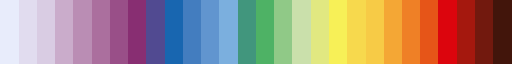

In [14]:
mean_cmap

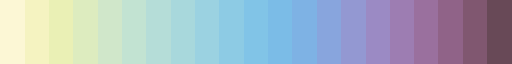

In [15]:
count_cmap

## Paper plots

In [32]:

mean_lims = (1e-6, 5e-3) # higher max so you don't saturate the convective plots


#### SPC

In [33]:
region = "SPC"


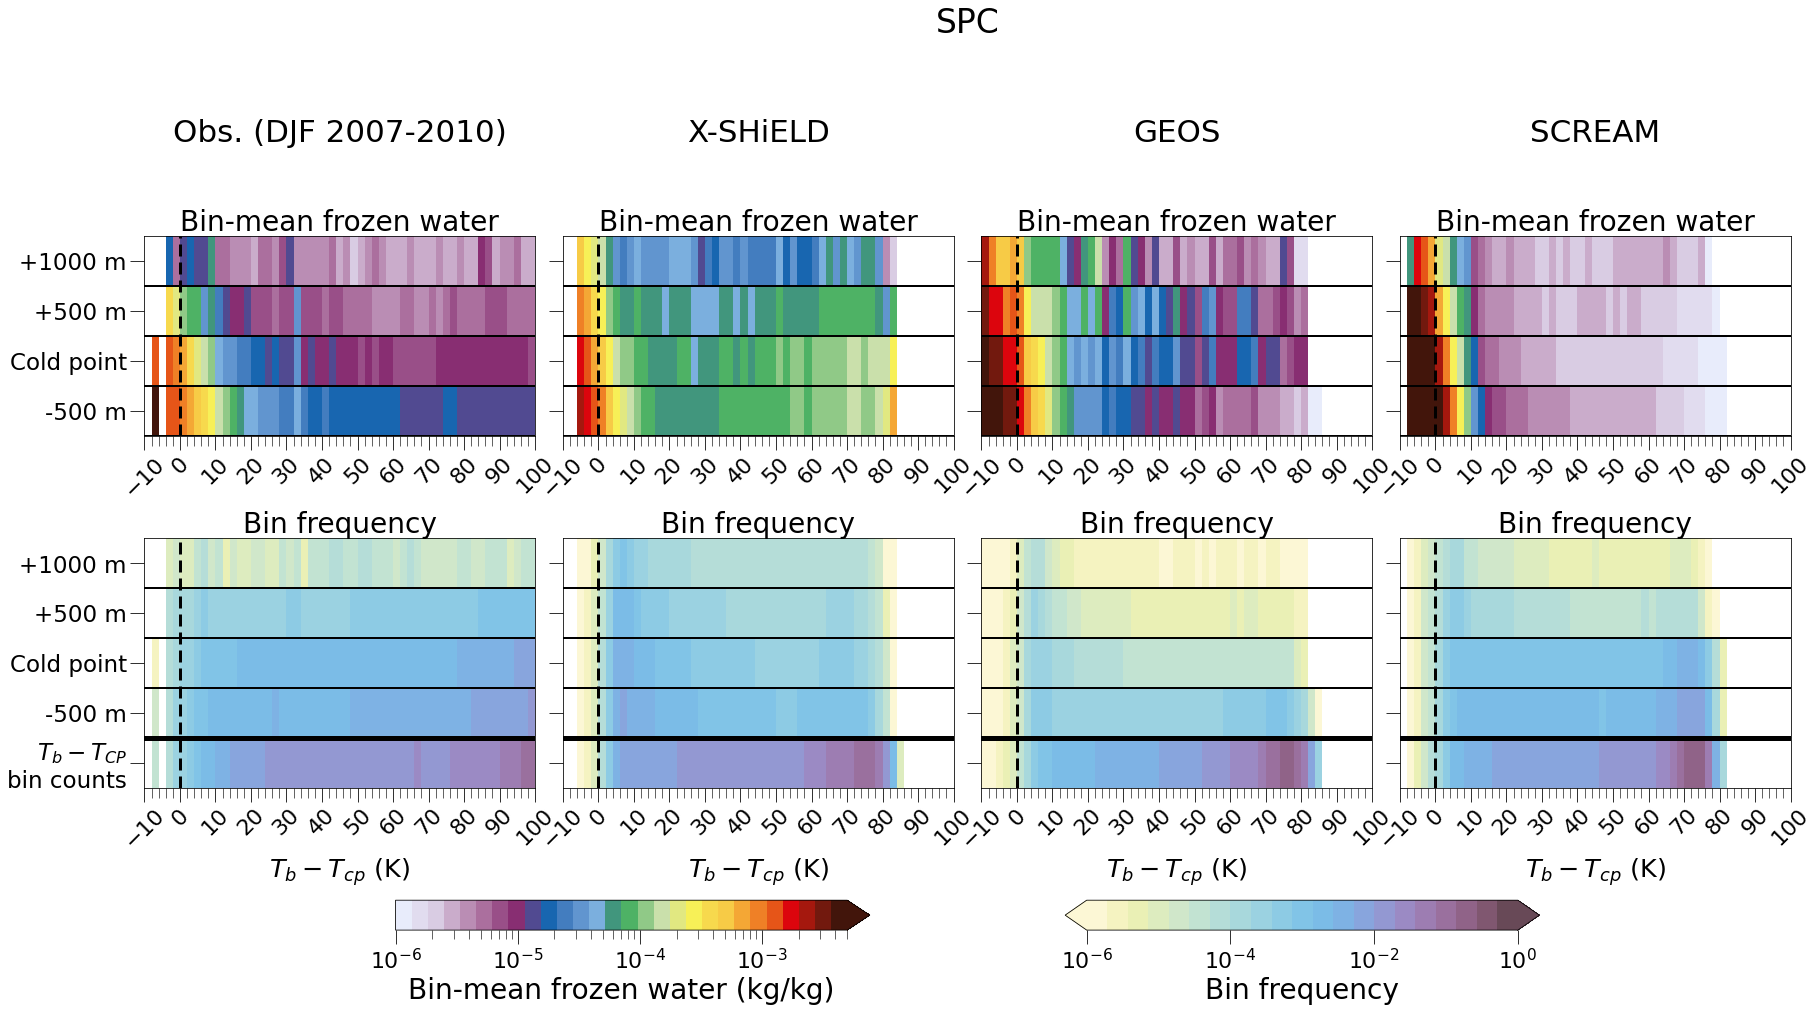

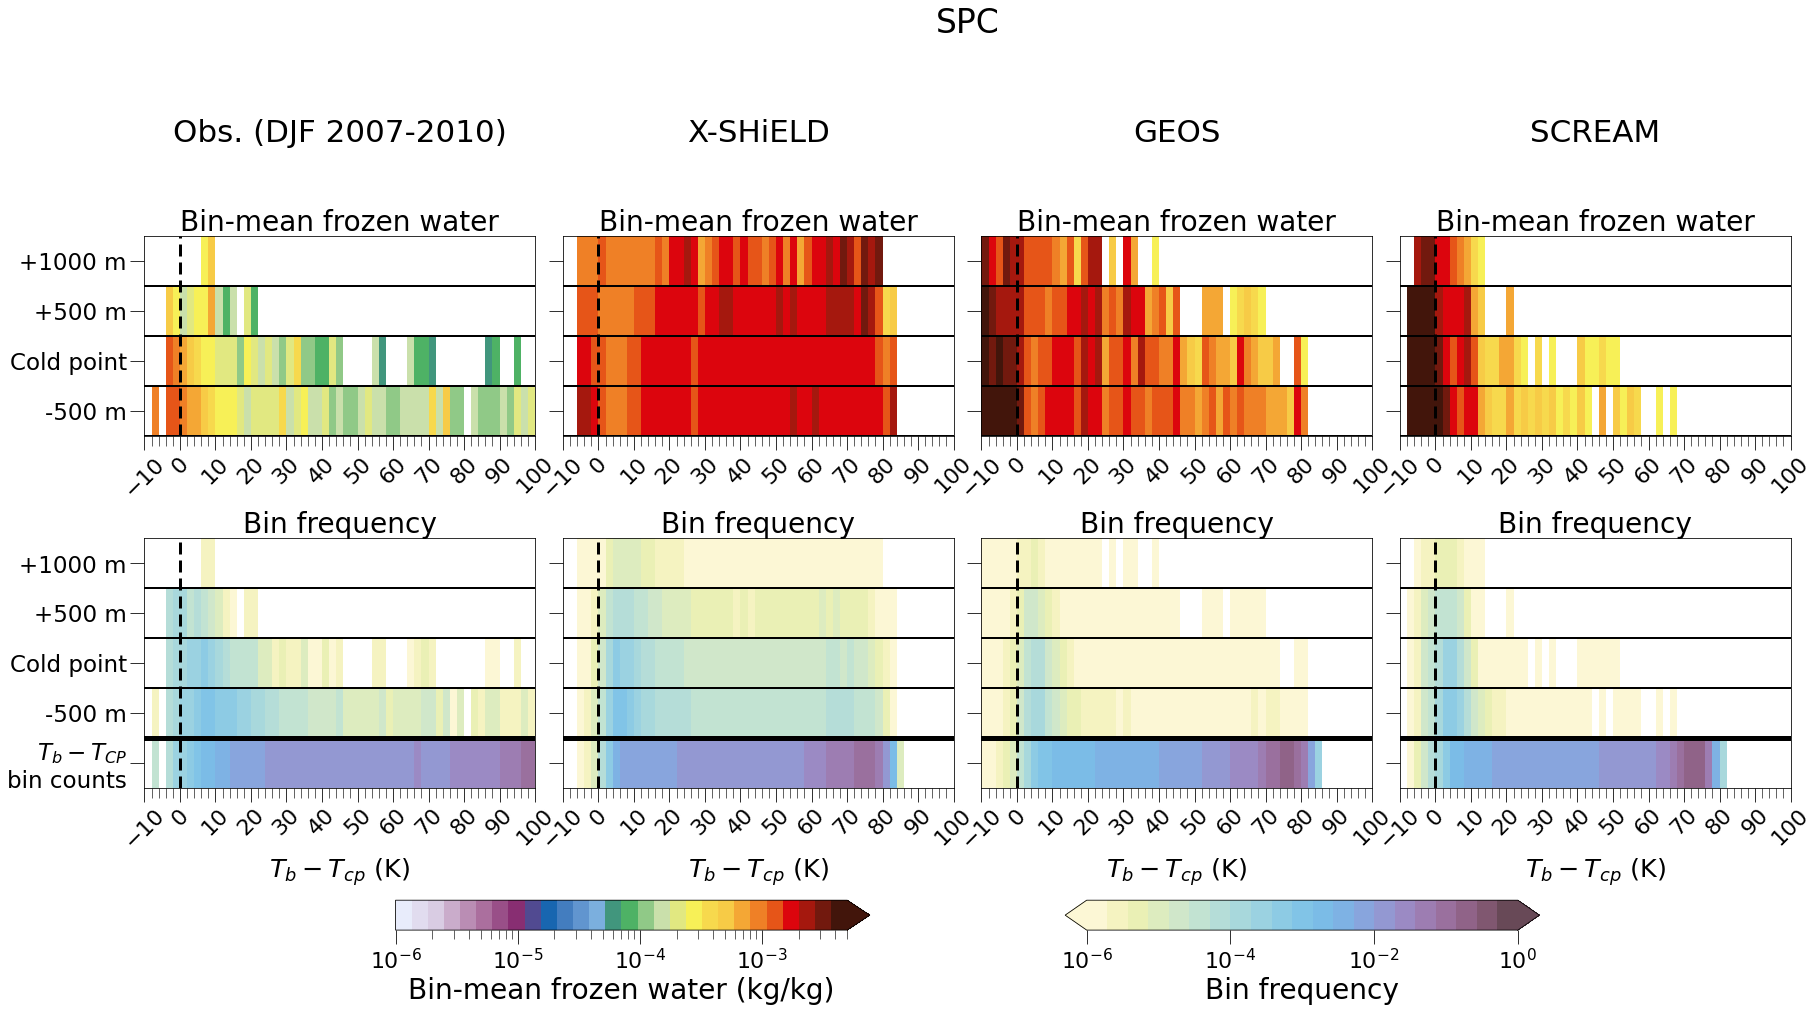

In [34]:
# region = "SPC"
qtot_means_dict = qtot_means_region_dict[region]
qtot_conv_means_dict = qtot_conv_means_region_dict[region]
qtot_counts_dict = qtot_counts_region_dict[region]
qtot_conv_counts_dict = qtot_conv_counts_region_dict[region]

diffs_counts_dict = diffs_counts_region_dict[region]
       
plot_all_one_region("qtot", qtot_means_dict, qtot_counts_dict, diffs_counts_dict, region, model_list, title_dict,
                       mean_lims=mean_lims, diffs_lims=diffs_lims, count_lims=count_lims, fsize=fsize, labsize=labsize,
                       tsize=tsize, figsize=figsize, count_cmap=count_cmap, mean_cmap=mean_cmap, vert_cbar=False, hspace=hspace,
                        save=True, save_dir=save_dir, plot_freq=True)

# qi thresh for models, instrument type for obs
plot_all_one_region("qtot_conv", qtot_conv_means_dict, qtot_conv_counts_dict, diffs_counts_dict, region, model_list, title_dict,
                       mean_lims=mean_lims, diffs_lims=diffs_lims, count_lims=count_lims, fsize=fsize, labsize=labsize,
                       tsize=tsize, figsize=figsize, count_cmap=count_cmap, mean_cmap=mean_cmap, vert_cbar=False, hspace=hspace,
                        save=True, save_dir=save_dir, plot_freq=True, save_ext="_obs_instr_25e-4")



#### AMZ

In [35]:
region = "AMZ"

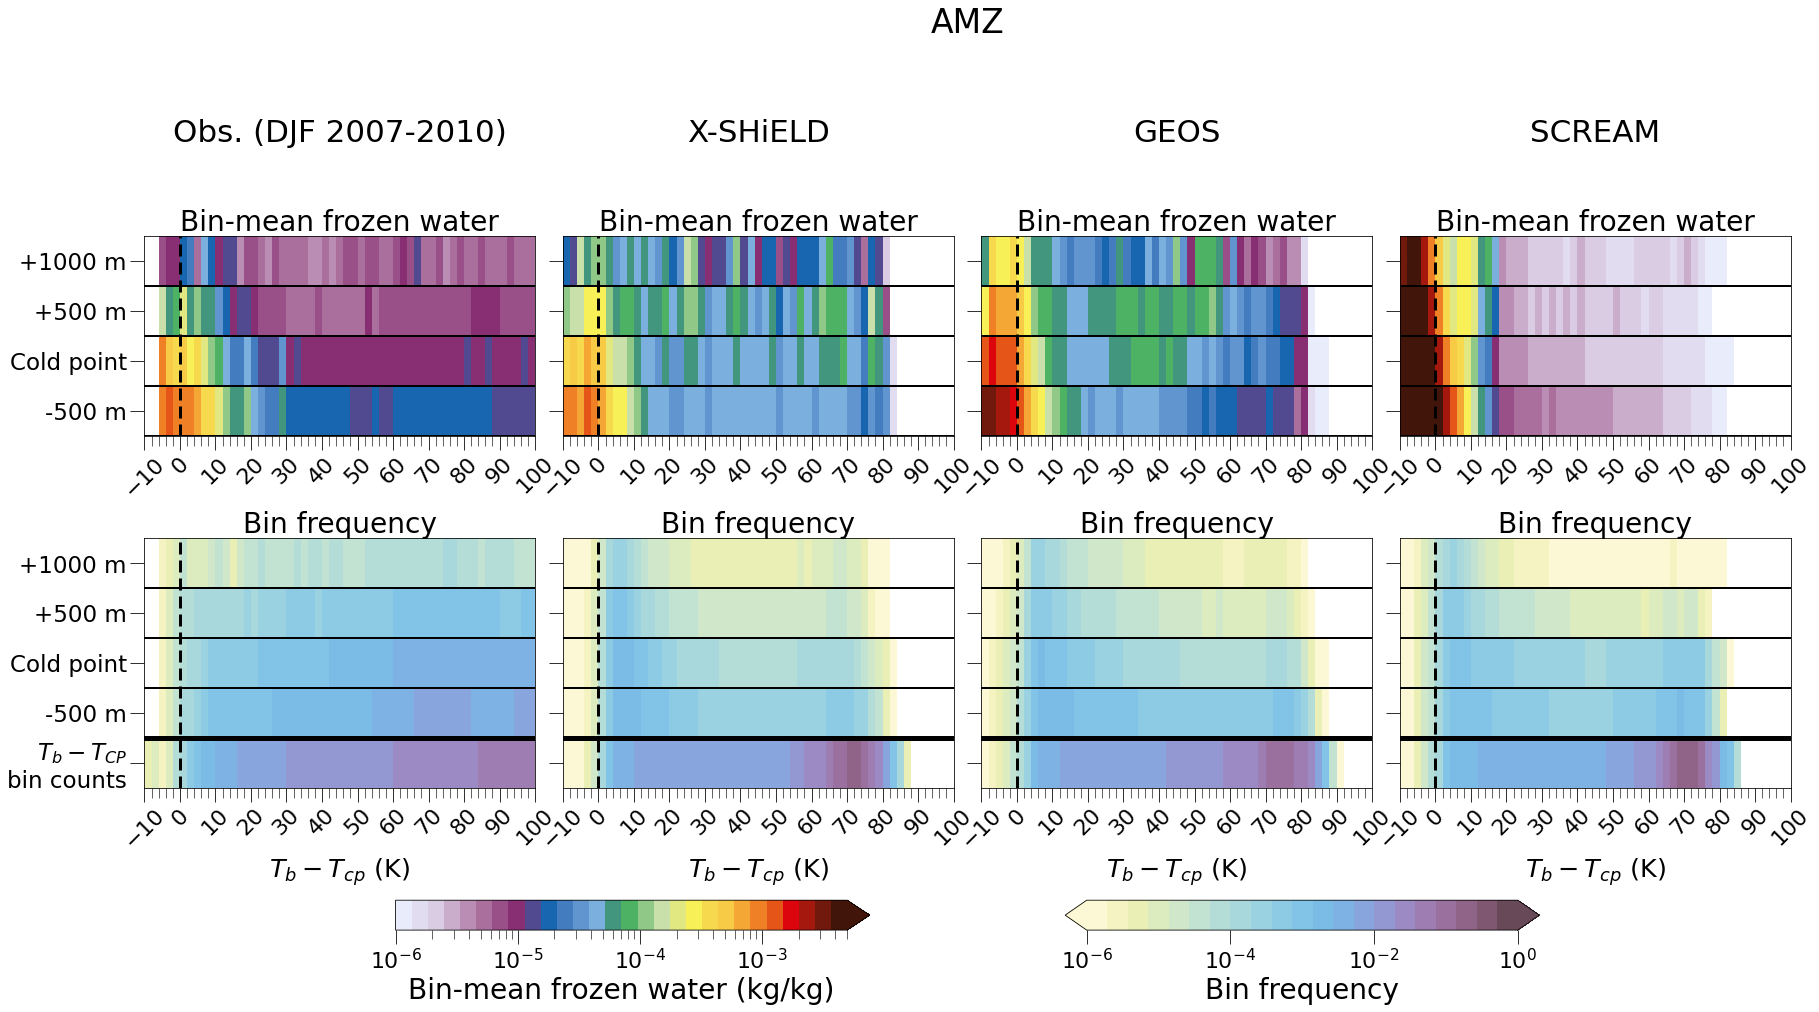

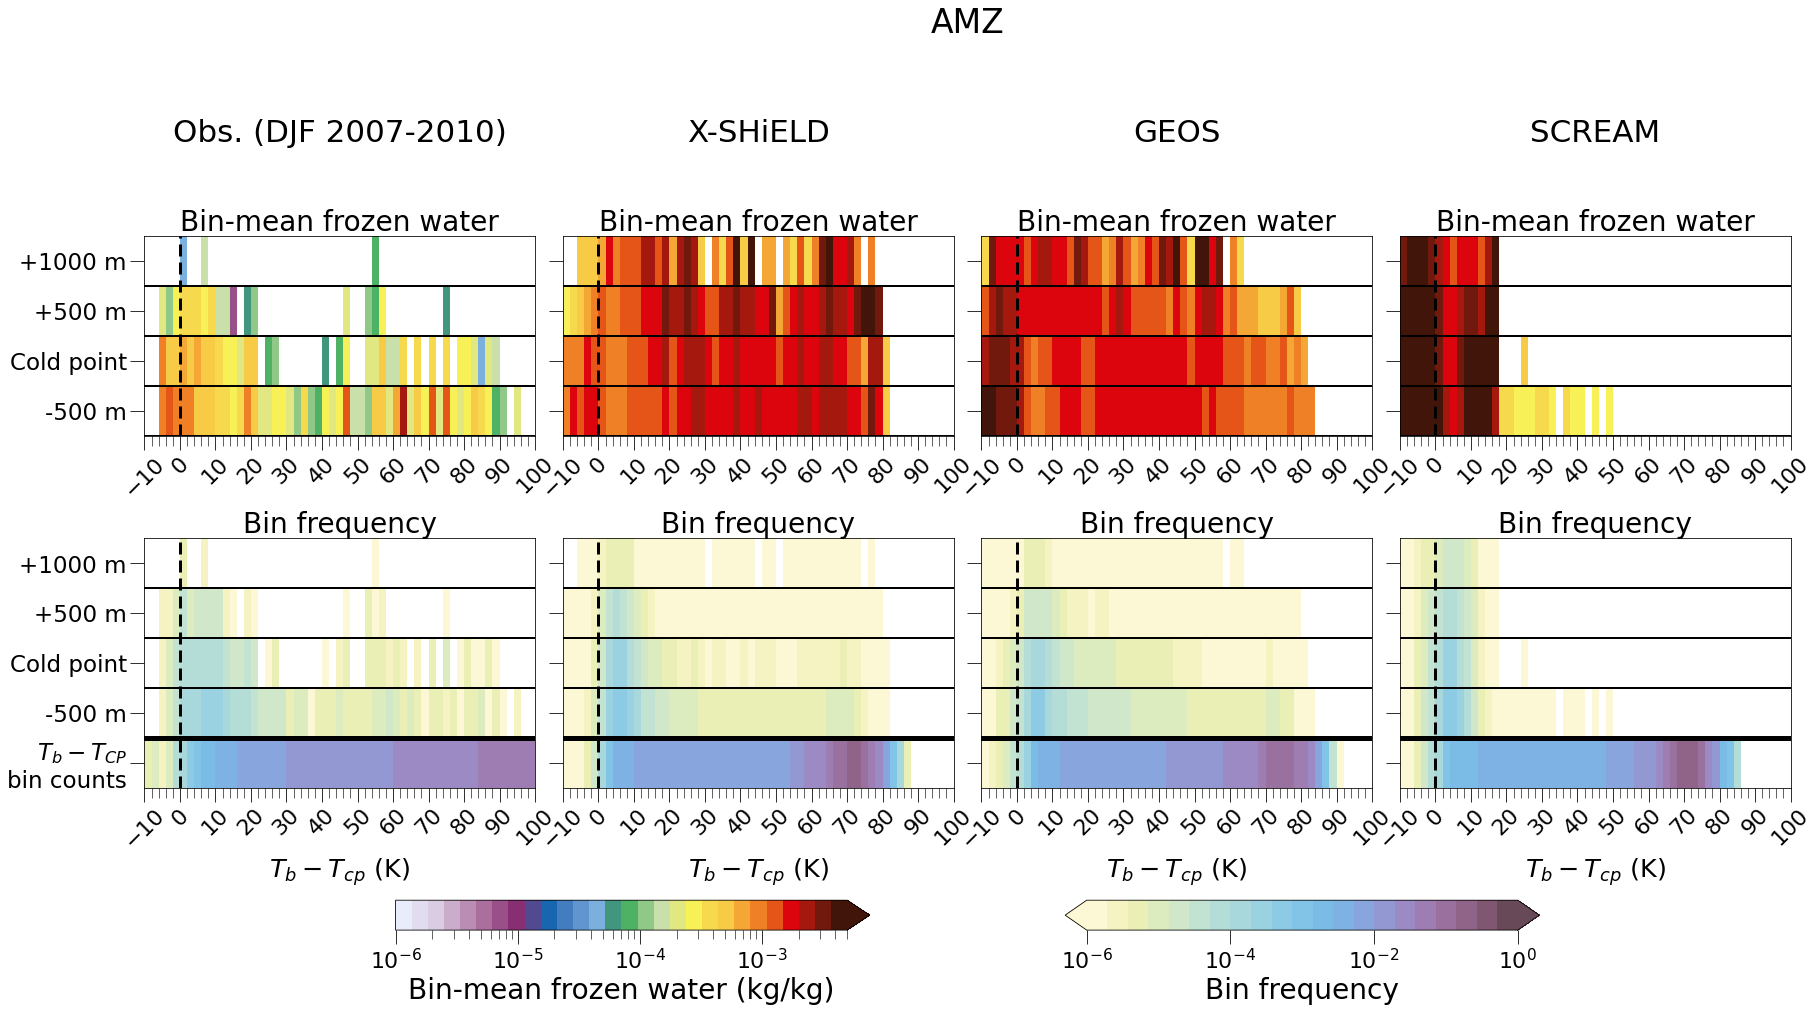

In [36]:
# region = "SPC"
qtot_means_dict = qtot_means_region_dict[region]
qtot_conv_means_dict = qtot_conv_means_region_dict[region]
qtot_counts_dict = qtot_counts_region_dict[region]
qtot_conv_counts_dict = qtot_conv_counts_region_dict[region]

diffs_counts_dict = diffs_counts_region_dict[region]
       
plot_all_one_region("qtot", qtot_means_dict, qtot_counts_dict, diffs_counts_dict, region, model_list, title_dict,
                       mean_lims=mean_lims, diffs_lims=diffs_lims, count_lims=count_lims, fsize=fsize, labsize=labsize,
                       tsize=tsize, figsize=figsize, count_cmap=count_cmap, mean_cmap=mean_cmap, vert_cbar=False, hspace=hspace,
                        save=True, save_dir=save_dir, plot_freq=True)

# qi thresh for models, instrument type for obs
plot_all_one_region("qtot_conv", qtot_conv_means_dict, qtot_conv_counts_dict, diffs_counts_dict, region, model_list, title_dict,
                       mean_lims=mean_lims, diffs_lims=diffs_lims, count_lims=count_lims, fsize=fsize, labsize=labsize,
                       tsize=tsize, figsize=figsize, count_cmap=count_cmap, mean_cmap=mean_cmap, vert_cbar=False, hspace=hspace,
                        save=True, save_dir=save_dir, plot_freq=True, save_ext="_obs_instr_25e-4")

